In [33]:
import setGPU

import math
from functools import partial

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jr
import diffrax as dfx
import matplotlib.pyplot as plt
import numpy as np

from einops import rearrange
from jaxtyping import Float as f, jaxtyped
from jax import Array
from typeguard import typechecked as typechecker
from check_shapes import check_shapes

import neural_diffusion_processes as ndp
from neural_diffusion_processes.types import Scalar, Optional, Union, Tuple


In [2]:
from jax.config import config
config.update("jax_enable_x64", False)
# JITTER = 1e-12
JITTER = 1e-6

In [57]:
from neural_diffusion_processes.kernels import gram

class MultivariateNormalDistribution:
    @jaxtyped
    @typechecker
    def __init__(self, mean: f[Array, "... nd"], scale: f[Array, "... nd nd"], **kwargs):
        # TODO: should we reshape mean (B, N, D) -> (B, N*D)
        # and scale                    (B, N, N, D, D) -> (B, N*D, N*D) ?
        self.mean = mean
        self.scale = scale
        # self.dist = dx.MultivariateNormalTri(mean, scale)

    def sample(self, seed, sample_shape) -> f[Array, "... nd"]:
        # return jnp.expand_dims(self.dist.sample(seed=rng, sample_shape=shape), -1)
        z = jax.random.normal(seed, (*sample_shape, *self.mean.shape))
        bijector = lambda z: self.mean + jnp.einsum("...ij,...j->...i", self.scale, z)
        bijector = jax.vmap(bijector) if sample_shape != () else bijector
        return bijector(z)


    @jaxtyped
    @typechecker
    def log_prob(self, z: f[Array, "... nd"]) -> f[Array, "..."]:
        shape = z.shape
        # return self.dist.log_prob(z.reshape(-1))

        M = jsp.linalg.solve_triangular(self.scale, z - self.mean, lower=True)
        M = jnp.power(M, 2).sum(-1)

        # Sigma = jnp.einsum("...ij,...kj->...ik", self.scale, self.scale)
        # M = jnp.einsum("...j,...ij->...i", z - self.mean, jnp.linalg.inv(Sigma))
        # M = jnp.einsum("...ij,...j->...i", M, z - self.mean)
        # half_log_det = 0.5 * jnp.log(vmap(jnp.linalg.det)(Sigma))
        diag = jnp.diag if len(shape) == 1 else jax.vmap(jnp.diag)
        half_log_det = jnp.log(diag(self.scale)).sum(-1)
        logp = -0.5 * (shape[-1] * math.log(2 * math.pi) + M) - half_log_det
        return logp


@jaxtyped
@typechecker
def gp_prior(mean_fn, kernel, x: f[Array, "... n d"], noise=0.0):
    # print("x", x.shape)
    shape = x.shape
    n_test = shape[-2]
    μt = mean_fn(x)
    μt = rearrange(μt, "... n d -> ... (n d)")
    # print("μt", μt.shape)
    gram_kernel = partial(gram, kernel)
    Ktt = jax.vmap(gram_kernel)(x) if len(shape) > 2 else gram_kernel(x)
    # print("Ktt", Ktt.shape)
    # print("Ktt", Ktt)
    if len(Ktt.shape) > 3:
        n_test *= Ktt.shape[-1]
        Ktt = rearrange(Ktt, "... n m d1 d2 -> ... (n d1) (m d2)")
        # print("Ktt", Ktt.shape)
    # print("n_test", n_test)
    Ktt += (JITTER + noise) * jnp.eye(n_test)
    scale = jnp.linalg.cholesky(Ktt)
    # dist = dx.MultivariateNormalFullCovariance(μt, Ktt)
    # dist = dx.MultivariateNormalTri(μt, scale)
    dist = MultivariateNormalDistribution(μt, scale)
    return dist


@jaxtyped
@typechecker
def gp_posterior(
    mean_fn,
    kernel,
    x: f[Array, "... n x_dim"],
    # y: Union[f[Array, "... nd"], f[Array, "... n d"]],
    y: f[Array, "... n d"],
    x_eval: f[Array, "... m x_dim"],
    noise=0.0,
):
    shape = x.shape
    n = shape[-2]
    μx = mean_fn(x)
    # if y.shape[-1] == x.shape:
        # y = rearrange(y, "... n d -> ... (n d)")
    y = rearrange(y, "... n d -> ... (n d)")
    μx = rearrange(μx, "... n d -> ... (n d)")
    # print("μx", μx.shape)
    gram_kernel = partial(gram, kernel)
    Kxx = jax.vmap(gram_kernel)(x) if len(shape) > 2 else gram_kernel(x)
    # print("Kxx", Kxx.shape)
    if len(Kxx.shape) > 3:
        n *= Kxx.shape[-1]
        Kxx = rearrange(Kxx, "... n m d1 d2 -> ... (n d1) (m d2)")
        # print("Kxx", Kxx.shape)
    Kxx += (JITTER + noise) * jnp.eye(n)  # shape = [b (n d) (n d)]

    L = jnp.linalg.cholesky(Kxx)  # shape = [b (n d) (n d)]
    # print("L", L.shape)
    # print("y", y.shape)
    # print("μx", μx.shape)
    # w = L⁻¹ (y - μx)
    w = jsp.linalg.solve_triangular(L, y - μx, lower=True)  # shape = [b (n d)]
    # print("w", w.shape)

    μt = mean_fn(x_eval)  # shape = [b n d]
    # print("μt", μt.shape)
    μt = rearrange(μt, "... n d -> ... (n d)")  # shape = [b (n d)]
    # print("μt", μt.shape)

    shape = x_eval.shape
    n_test = shape[-2]
    Ktt = jax.vmap(gram_kernel)(x_eval) if len(shape) > 2 else gram_kernel(x_eval)
    # print("Ktt", Ktt.shape)
    # Kxt = jax.vmap(gram_kernel)(x, x_eval) if len(shape) > 2 else gram_kernel(x, x_eval)
    if len(x.shape) <= 2 and len(x_eval.shape) <= 2:
        Kxt = gram_kernel(x, x_eval)
    elif len(x.shape) > 2 and len(x_eval.shape) <= 2:
        Kxt = jax.vmap(lambda data: gram_kernel(data, x_eval))(x)
    elif len(x.shape) <= 2 and len(x_eval.shape) > 2:
        Kxt = jax.vmap(lambda data: gram_kernel(x, data))(x_eval)
    else:
        Kxt = jax.vmap(gram_kernel)(x, x_eval)
    # print("Kxt", Kxt.shape)
    if len(Kxt.shape) > 3:
        n_test *= Ktt.shape[-1]
        Ktt = rearrange(Ktt, "... n m d1 d2 -> ... (n d1) (m d2)")
        # print("Ktt", Ktt.shape)
        Kxt = rearrange(Kxt, "... n m d1 d2 -> ... (n d1) (m d2)")
        # print("Kxt", Kxt.shape)

    # L⁻¹ Kxt
    L_inv_Kxt = jsp.linalg.solve_triangular(L, Kxt, lower=True)  # shape = [b (n d) (m d)]
    # print("L_inv_Kxt", L_inv_Kxt.shape)

    # μt  +  Ktx (Kzz + Iσ²)⁻¹ (y  -  μx)
    L_inv_Kxt_T = jnp.einsum("...ij->...ji", L_inv_Kxt)  # shape = [b (m d) (n d)]
    # print("L_inv_Kxt_T", L_inv_Kxt_T.shape)

    # mean = μt + jnp.einsum("...ji,...j->...i", L_inv_Kxt, w)
    mean = μt + jnp.einsum("...ij,...j->...i", L_inv_Kxt_T, w)  # shape = [b (m d)]
    # print("mean", mean.shape)

    # Ktt  -  Ktz (Kzz + Iσ²)⁻¹ Kxt  [recall (Kzz + Iσ²)⁻¹ = (LLᵀ)⁻¹ =  L⁻ᵀL⁻¹]
    # print(jnp.einsum("...ij,...jk->...ik", L_inv_Kxt_T, L_inv_Kxt).shape)
    covariance = Ktt - jnp.einsum("...ij,...jk->...ik", L_inv_Kxt_T, L_inv_Kxt)
    # print("n_test", n_test)
    covariance += (JITTER + noise) * jnp.eye(n_test)  # shape = [b (m d) (m d)]
    # print("covariance", covariance.shape)

    scale = jnp.linalg.cholesky(covariance)
    dist = MultivariateNormalDistribution(mean, scale)
    return dist


In [58]:
beta_schedule = ndp.sde.LinearBetaSchedule()
# x = jnp.linspace(-1, 1, 103)
x = jnp.linspace(-1, 1, 50)
x1, x2 = jnp.meshgrid(x, x)
x = jnp.stack([x1.flatten(), x2.flatten()], axis=-1)
print(x.shape)
# k0 = ndp.kernels.SquaredExpontialKernel(lengthscale=0.25)
k0 = ndp.kernels.RBFVec(lengthscale=0.25)
k1 = ndp.kernels.WhiteKernel()
# k1 = ndp.kernels.SquaredExpontialKernel(lengthscale=1.0)
mean_function = ndp.kernels.Zero(output_dim=2)  # A zero mean function

(2500, 2)


In [59]:
seed = 42
key = jax.random.PRNGKey(seed)

# Solves forward SDE for multiple initia states using vmap.
num_samples = 1
key, subkey = jax.random.split(key)
# y0s = sample_gp(subkey, k0, mean_function, x, num_samples=num_samples)
dist = gp_prior(mean_function, k0, x, noise=1e-5)
y0s = dist.sample(subkey, (num_samples,))
# y0s

x_context = jnp.array([[1, 2], [2, 1], [-1, -1]]).astype(float)
y_context = jnp.array([[1, 1], [1, -2], [-4, 3]]).astype(float)
posterior = gp_posterior(mean_function, k0, x_context, y_context, x)
y = posterior.mean
y

Array([-3.9999971e+00,  2.9999981e+00, -3.9470396e+00, ...,
       -1.3538869e-05,  6.7092472e-04, -3.3546233e-04], dtype=float32)

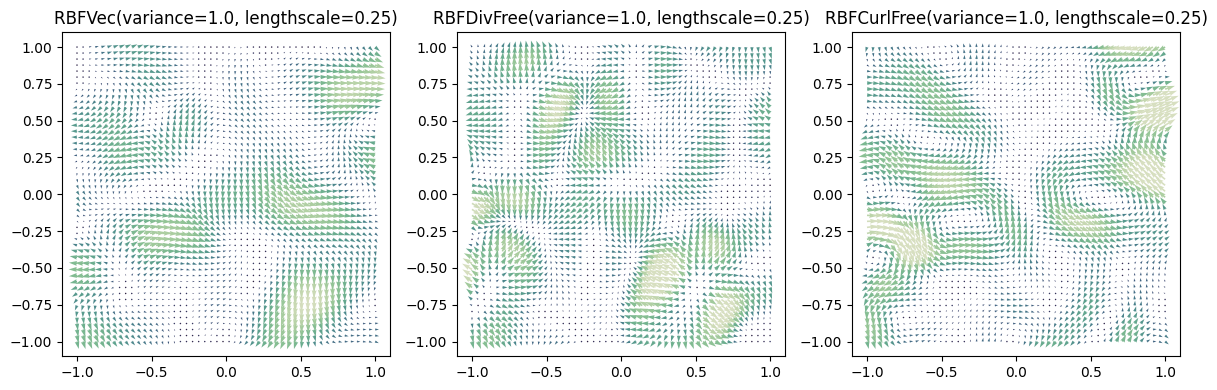

In [60]:

import matplotlib
import seaborn as sns

dim = 2
# rbf = ndp.kernels.RBFKernel(lengthscale=0.25)
kernels = [
    ndp.kernels.RBFVec(lengthscale=0.25),
    ndp.kernels.RBFDivFree(lengthscale=0.25),
    ndp.kernels.RBFCurlFree(lengthscale=0.25)
    ]

norm = matplotlib.colors.Normalize()
cm = sns.cubehelix_palette(start=0.5, rot=-0.75, as_cmap=True, reverse=True)

#%% prior
fig, axes = plt.subplots(
    1,
    len(kernels),
    figsize=(len(kernels) * 4, 4),
    sharex=False,
    sharey="col",
    tight_layout=True,
)

key, subkey = jax.random.split(key)
for ax, kernel in zip(axes, kernels):
    ax.set_title(kernel)
    y = gp_prior(mean_function, kernel, x, noise=1e-5).sample(subkey, ())
    y = rearrange(y, "... (n d) -> ... n d", d=dim)
    y_norm = jnp.linalg.norm(y, axis=-1)
    ax.quiver(
        x[:, 0],
        x[:, 1],
        y[:, 0],
        y[:, 1],
        color=cm(norm(y_norm)),
        scale=80,
        width=0.005,
    )

theta = 75.77 degrees


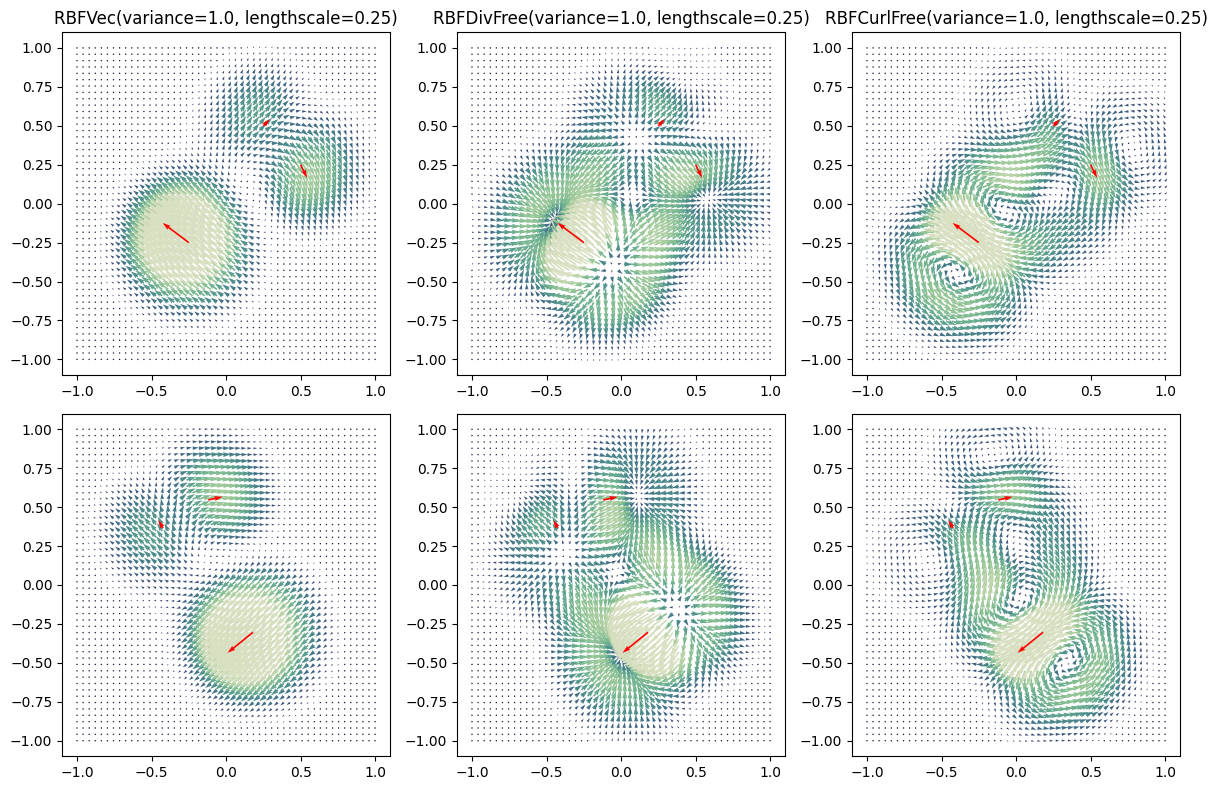

In [68]:

x_context = jnp.array([[1, 2], [2, 1], [-1, -1]]) / 4
y_context = jnp.array([[1, 1], [1, -2], [-4, 3]])

fig, axes = plt.subplots(
    2,
    len(kernels),
    figsize=(len(kernels) * 4, 2 * 4),
    sharex=False,
    sharey="col",
    tight_layout=True,
)

# key, subkey = jax.random.split(key)
theta = jax.random.uniform(subkey) * jnp.pi
print(f"theta = {theta*360/2/jnp.pi:.2f} degrees")
R = jnp.array([[jnp.cos(theta), -jnp.sin(theta)], [jnp.sin(theta), jnp.cos(theta)]])
I = jnp.eye(2)

for ax, kernel in zip(axes.T, kernels):
    ax[0].set_title(kernel)

    for k, rot in enumerate([I, R]):
        posterior = gp_posterior(mean_function, kernel, x_context @ rot.T, y_context @ rot.T, x)
        y = posterior.mean
        # Y = posterior.sample(seed=next_rng, sample_shape=())
        y = rearrange(y, "... (n d) -> ... n d", d=dim)
        y_norm = jnp.linalg.norm(y, axis=-1)

        ax[k].quiver(
            x[:, 0],
            x[:, 1],
            y[:, 0],
            y[:, 1],
            color=cm(norm(y_norm)),
            scale=50,
            width=0.005,
        )

        ax[k].quiver(
            (x_context @ rot.T)[:, 0],
            (x_context @ rot.T)[:, 1],
            (y_context @ rot.T)[:, 0],
            (y_context @ rot.T)[:, 1],
            color="r",
            scale=50,
            width=0.005,
        )
